# MVP Análise de Dados e Boas Práticas
## Análise da Demanda de Medicamentos para Câncer de Próstata (Estágio Avançado)

**Nome:** Juliana Silva

**Matrícula:** 4052025000237

**Dataset:** Demanda_Medicamentos.csv

**Contexto**

O câncer de próstata representa uma das principais causas de mortalidade masculina no Brasil, especialmente em estágios avançados ou metastáticos da doença. Nessa etapa, o tratamento farmacológico é essencial e envolve medicamentos altamente especializados, cujo consumo e valor movimentado podem refletir aspectos cruciais relacionados ao acesso à saúde, gestão hospitalar, disponibilidade regional e estratégias comerciais das empresas farmacêuticas.

Este projeto utiliza dados reais fornecidos pela empresa IQVIA, líder global em informações relacionadas à saúde, onde atuo profissionalmente. Os dados foram devidamente anonimizados, garantindo total confidencialidade e conformidade com as normas éticas de privacidade e segurança da informação.

---

**Objetivo**

O objetivo deste projeto é realizar uma análise exploratória profunda sobre uma base de dados real, focando em medicamentos específicos para o tratamento do câncer de próstata em estágio avançado. O estudo tem duas vertentes complementares:

* Modelo Preditivo de Regressão: Construir e validar um modelo preditivo capaz de estimar o valor monetário das vendas com base em atributos importantes como localização geográfica (estado, região), características do produto (marca, concentração), canal de venda (hospitalar, farmácia ou outros) e quantidade comercializada;

* Modelo de Previsão de Séries Temporais: Desenvolver uma previsão mensal das vendas totais (em valor e unidades) para os próximos meses, utilizando o modelo Prophet, identificando tendências e auxiliando no planejamento estratégico futuro.

---

**Tipo de problema**

Trata-se de um problema de aprendizado supervisionado envolvendo duas abordagens:

* Regressão: para estimar o valor da venda individual com base em atributos explicativos.

* Previsão Temporal: para estimar a demanda mensal total (valor e unidades) em períodos futuros.

---

**Premissas**

* A base de dados fornecida representa um conjunto confiável e representativo das vendas nacionais de medicamentos oncológicos específicos.

* O valor monetário das vendas ("VALOR") é influenciado significativamente por fatores como canal de distribuição, localização geográfica (cidade e região), tipo de medicamento e características específicas do produto (marca, concentração, quantidade).

* A demanda mensal segue padrões históricos que podem ser capturados por modelos temporais, possibilitando previsões eficazes.

---

**Restrições**

* Utilização exclusiva de dados não sigilosos e completamente anonimizados, respeitando todas as normas de privacidade.

* Trabalhar com uma base de dados limpa, que não tenha sofrido tratamentos prévios significativos ou transformações que alterem as características originais dos dados.

Essa abordagem dupla permite uma compreensão robusta e estratégica do mercado desses medicamentos, ajudando a embasar decisões relacionadas à gestão pública e privada da saúde, estratégias comerciais, logísticas e políticas de acesso aos tratamentos.


### 2. Carregamento e Visualização Inicial dos Dados

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
from IPython.display import display

In [166]:
# Configurações de exibição
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid")

# Carregamento dos dados (leitura com separador ;)
url = ("https://raw.githubusercontent.com/JuulianaS/MVP-An-lise-de-Dados-e-Boas-Pr-ticas/refs/heads/main/Demanda_Medicamentos.csv")
df = pd.read_csv(url, sep=';')

# Visualizar as primeiras linhas do dataset
df.head()

,DT_PERIODO,SG_UF,DC_CIDADE,PRODUTO,CONCENTRACAO,QDTE_PRODUTO,MARCA,CANAL,CLASSE_TERAPEUTICA,INDICAÇÃO,FORMA_FARMACEUTICA,DC_NACIONAL_MULTINACIONAL,DC_GRMS,DC_ETICO_POPULAR,DC_CONCENTRACAO,PACK_DCT_DISEASE_DESC,PACK_IS_RX_IND,UNIDADES,VALOR
0,202302,AL,MACEIO,PROD_B,250MG,120,MARCA_A,HOSPITALAR,ANTIANDRÓGENOS NÃO ESTEROIDES,TRATAMENTO DO CÂNCER DE PRÓSTATA METÁTICO RESI...,COMPRIMIDOS ORAIS,MULTINACIONAL,GENERICO,ETICO,MG,CANCER,MEDICAMENTO_PRESCRITO,4,33168.16
1,202302,BA,SALVADOR,PROD_B,250MG,120,MARCA_A,HOSPITALAR,ANTIANDRÓGENOS NÃO ESTEROIDES,TRATAMENTO DO CÂNCER DE PRÓSTATA METÁTICO RESI...,COMPRIMIDOS ORAIS,MULTINACIONAL,GENERICO,ETICO,MG,CANCER,MEDICAMENTO_PRESCRITO,1,8292.04
2,202302,BA,TEIXEIRA DE FREITAS,PROD_B,250MG,120,MARCA_A,OUTROS,ANTIANDRÓGENOS NÃO ESTEROIDES,TRATAMENTO DO CÂNCER DE PRÓSTATA METÁTICO RESI...,COMPRIMIDOS ORAIS,MULTINACIONAL,GENERICO,ETICO,MG,CANCER,MEDICAMENTO_PRESCRITO,2,16584.08
3,202302,BA,TEIXEIRA DE FREITAS,PROD_B,250MG,120,MARCA_A,FARMACIA,ANTIANDRÓGENOS NÃO ESTEROIDES,TRATAMENTO DO CÂNCER DE PRÓSTATA METÁTICO RESI...,COMPRIMIDOS ORAIS,MULTINACIONAL,GENERICO,ETICO,MG,CANCER,MEDICAMENTO_PRESCRITO,3,24876.12
4,202302,BA,VITORIA DA CONQUISTA,PROD_B,250MG,120,MARCA_A,OUTROS,ANTIANDRÓGENOS NÃO ESTEROIDES,TRATAMENTO DO CÂNCER DE PRÓSTATA METÁTICO RESI...,COMPRIMIDOS ORAIS,MULTINACIONAL,GENERICO,ETICO,MG,CANCER,MEDICAMENTO_PRESCRITO,1,8292.04


Análise inicial:
O dataset possui múltiplas variáveis categóricas e numéricas, essenciais para uma análise detalhada do comportamento de vendas

### 3. Dicionário de Atributos

* **DT_PERIODO:** Ano e mês da venda
* **SG_UF:** Sigla da unidade federativa (estado)
* **DC_CIDADE:** Nome da cidade
* **PRODUTO:** Nome do produto
* **CONCENTRACAO:** Dosagem do produto
* **QDTE_PRODUTO:** Quantidade do produto
* **MARCA:** Nome da marca
* **CANAL:** Canal de venda (farmácia, hospital, outros)
* **CLASSE_TERAPEUTICA**: Classe do medicamento
* **INDICAÇÃO:** Indicação terapêutica
* **FORMA_FARMACEUTICA:** Forma (ex: comprimido)
* **DC_NACIONAL_MULTINACIONAL:** Origem da empresa
* **DC_GRMS:** Categoria regulatória (genérico etc.)
* **DC_ETICO_POPULAR:** Tipo de medicamento
* **DC_CONCENTRACAO:** Unidade de concentração (ex: mg)
* **PACK_DCT_DISEASE_DESC:** Doença associada (ex: Câncer)
* **PACK_IS_RX_IND:** Medicamento prescrito ou não
* **UNIDADES:** Quantidade de unidades vendidas
* **VALOR:** Valor monetário da venda


---


A base combina atributos temporais, geográficos, comerciais e clínicos, o que permite uma análise rica.

Os atributos numéricos (VALOR, UNIDADES, QDTE_PRODUTO) são chave para a modelagem.

Os categóricos como CANAL, MARCA, PRODUTO e SG_UF são importantes para segmentações e explicações do valor.

Atributos como INDICAÇÃO e CLASSE_TERAPEUTICA são úteis para confirmar o escopo clínico, embora menos usados em modelagem.

### 4. Informações Básicas e Tipos de Dados

In [167]:
# Verificar o formato do dataset
print("Formato do dataset:", df.shape)

Formato do dataset: (53388, 19)



*   Ajuda a ter uma noção do volume de dados disponíveis para análise.
*   Fundamental para saber se o dataset tem ampla cobertura ou se é necessário reduzir ou amostrar dados.

In [168]:
# Mostra os tipos de dados
print("\nTipos de dados:")
print(df.dtypes)


Tipos de dados:
DT_PERIODO                     int64
SG_UF                         object
DC_CIDADE                     object
PRODUTO                       object
CONCENTRACAO                  object
QDTE_PRODUTO                   int64
MARCA                         object
CANAL                         object
CLASSE_TERAPEUTICA            object
INDICAÇÃO                     object
FORMA_FARMACEUTICA            object
DC_NACIONAL_MULTINACIONAL     object
DC_GRMS                       object
DC_ETICO_POPULAR              object
DC_CONCENTRACAO               object
PACK_DCT_DISEASE_DESC         object
PACK_IS_RX_IND                object
UNIDADES                       int64
VALOR                        float64
dtype: object


**O que faz:**
Exibe o tipo de dado de cada coluna do DataFrame (ex: object, int64, float64).

**Por que isso é importante:**


*   Determina como cada variável será tratada na análise e modelagem.

    1.   object = categórico ou texto (precisa de codificação).
    2.   int64 ou float64 = numérico (pode ser escalado, padronizado, etc.).


*   Identifica se há necessidade de conversões (por exemplo: datas, números lidos como texto).
*   Impacta diretamente no pré-processamento.

In [169]:
# Verificar valores únicos por coluna
print("\nValores únicos por coluna:")
print(df.nunique())


Valores únicos por coluna:
DT_PERIODO                     24
SG_UF                          27
DC_CIDADE                     700
PRODUTO                         9
CONCENTRACAO                    6
QDTE_PRODUTO                    4
MARCA                           8
CANAL                           3
CLASSE_TERAPEUTICA              1
INDICAÇÃO                       1
FORMA_FARMACEUTICA              1
DC_NACIONAL_MULTINACIONAL       2
DC_GRMS                         3
DC_ETICO_POPULAR                1
DC_CONCENTRACAO                 1
PACK_DCT_DISEASE_DESC           1
PACK_IS_RX_IND                  1
UNIDADES                      216
VALOR                        1459
dtype: int64


**O que faz:**
Mostra quantos valores distintos (únicos) existem em cada coluna.

**Por que isso é importante:**


*   Ajuda a entender a variabilidade dos dados:

    1.   Variáveis com apenas 1 valor = inúteis (sem informação).
    2.   Variáveis com muitos valores únicos (ex: DC_CIDADE) = podem gerar alta cardinalidade → cuidado em codificação.


*   Ajuda na detecção de erros, por exemplo: colunas que deveriam ter poucos valores mas têm muitos (sinal de ruído ou erro de entrada).

### 5. Estatísticas Descritivas

In [170]:
# Resumo estatístico dos atributos numéricos
print(df[['QDTE_PRODUTO', 'UNIDADES', 'VALOR']].describe())

       QDTE_PRODUTO  UNIDADES       VALOR
count      53388.00  53388.00    53388.00
mean         115.49      5.92    63725.23
std           15.10     19.56   195498.09
min           56.00      1.00     8292.04
25%          120.00      1.00    14463.08
50%          120.00      2.00    26708.74
75%          120.00      5.00    54784.56
max          120.00   1375.00 12581827.50


**O que isso indica:**

QDTE_PRODUTO

  *   A maior parte dos registros apresenta valor fixo de 120.
  *   Quase nenhum desvio ou variação.

UNIDADES

  *   Varia de 1 a 1.375 unidades por venda, com média de ~6 unidades.
  *   O desvio padrão (19,56) é muito maior que a média (5,92) → isso indica alta dispersão.
  *   Há outliers evidentes em unidades vendidas.

VALOR

  *   Valores variam de 8 mil a mais de 12 milhões por venda.
  *   Média distorcida por outliers extremos.
  *   A mediana (R$ 26.708) é muito menor que a média → assimetria positiva forte. (É necessário tratar outliers e talvez normalizar essa variável.)






In [171]:
# Verificar valores ausentes
print("\nValores ausentes:")
print(df.isnull().sum())


Valores ausentes:
DT_PERIODO                   0
SG_UF                        0
DC_CIDADE                    0
PRODUTO                      0
CONCENTRACAO                 0
QDTE_PRODUTO                 0
MARCA                        0
CANAL                        0
CLASSE_TERAPEUTICA           0
INDICAÇÃO                    0
FORMA_FARMACEUTICA           0
DC_NACIONAL_MULTINACIONAL    0
DC_GRMS                      0
DC_ETICO_POPULAR             0
DC_CONCENTRACAO              0
PACK_DCT_DISEASE_DESC        0
PACK_IS_RX_IND               0
UNIDADES                     0
VALOR                        0
dtype: int64


Verifica se há valores ausentes (nulos) em cada coluna do dataset.

**O que isso indica:**

*   Não é necessário aplicar preenchimento ou remoção de dados faltantes.
*   Facilita a aplicação de algoritmos de machine learning, que exigem dados completos.
*   Isso é um bom sinal da qualidade dos dados fornecidos pela IQVIA, mostrando consistência.



### 6. Visualizações Iniciais

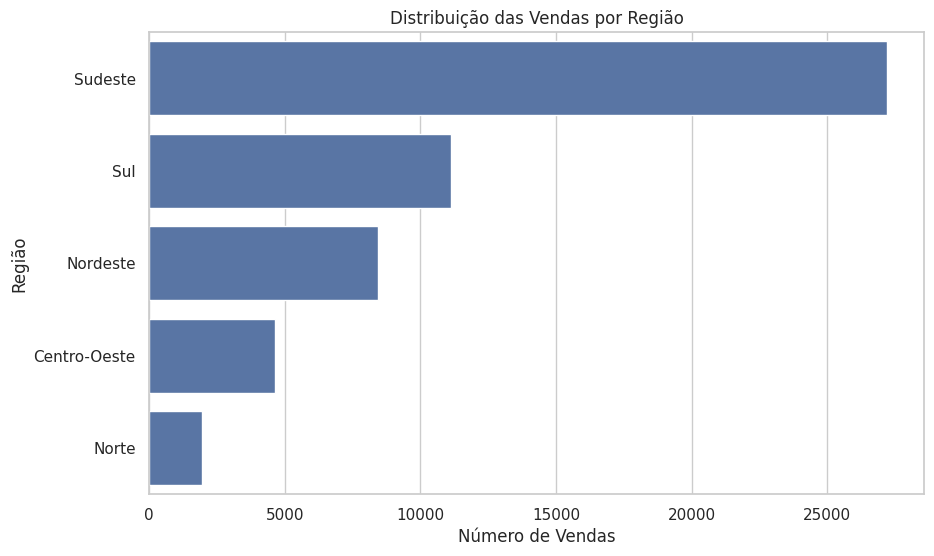

In [172]:
df['REGIAO'] = df['SG_UF'].map(lambda uf: (
    'Norte' if uf in ['AM', 'PA', 'TO', 'RO', 'RR', 'AC', 'AP'] else
    'Nordeste' if uf in ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'] else
    'Centro-Oeste' if uf in ['MT', 'MS', 'GO', 'DF'] else
    'Sudeste' if uf in ['SP', 'RJ', 'MG', 'ES'] else
    'Sul'
))

plt.figure(figsize=(10,6))
sns.countplot(y='REGIAO', data=df, order=df['REGIAO'].value_counts().index)
plt.title('Distribuição das Vendas por Região')
plt.xlabel('Número de Vendas')
plt.ylabel('Região')
plt.show()

**Análise:**

Podemos verificar se existe concentração de vendas em regiões específicas, o que ajudará na interpretação regional do mercado.

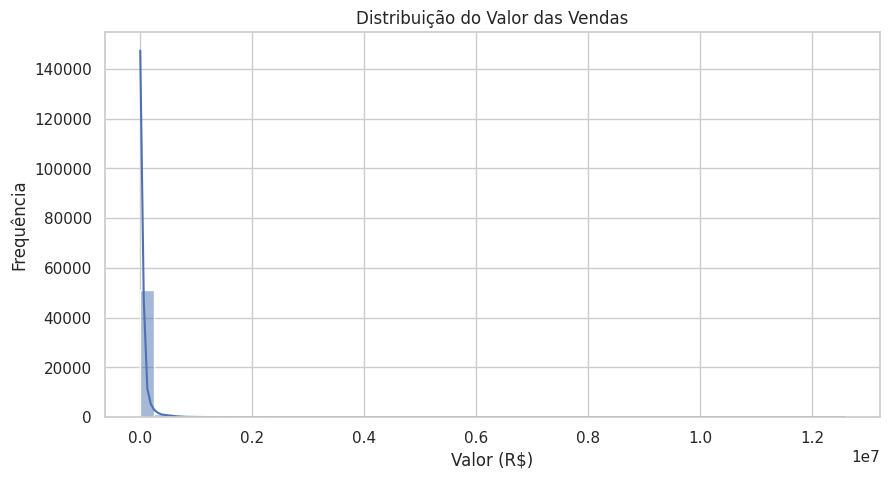

In [173]:
# Distribuição do valor de vendas
plt.figure(figsize=(10, 5))
sns.histplot(df['VALOR'], bins=50, kde=True)
plt.title('Distribuição do Valor das Vendas')
plt.xlabel('Valor (R$)')
plt.ylabel('Frequência')
plt.show()

**Observação:**


*   Há uma forte assimetria à direita, indicando presença de valores elevados que podem ser considerados outliers.
*   Presença de outliers com valores milionários, que devem ser tratados.



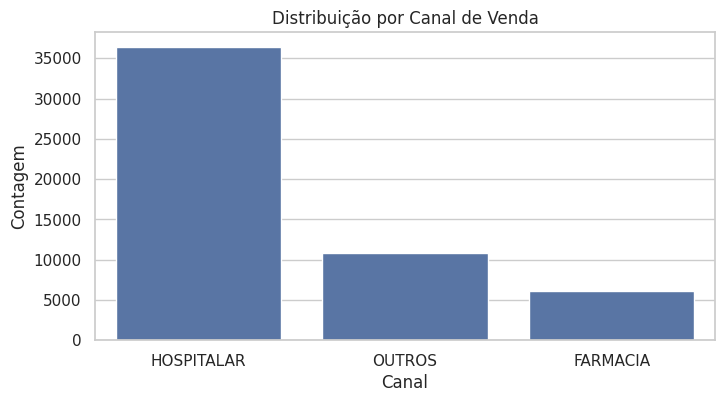

In [174]:
# Distribuição por canal
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='CANAL')
plt.title('Distribuição por Canal de Venda')
plt.xlabel('Canal')
plt.ylabel('Contagem')
plt.show()

**Observação:**

Canais hospitalares tendem a ter maior volume nesse tipo de medicamento especializado, mas a distribuição pode variar por região ou tipo de produto.

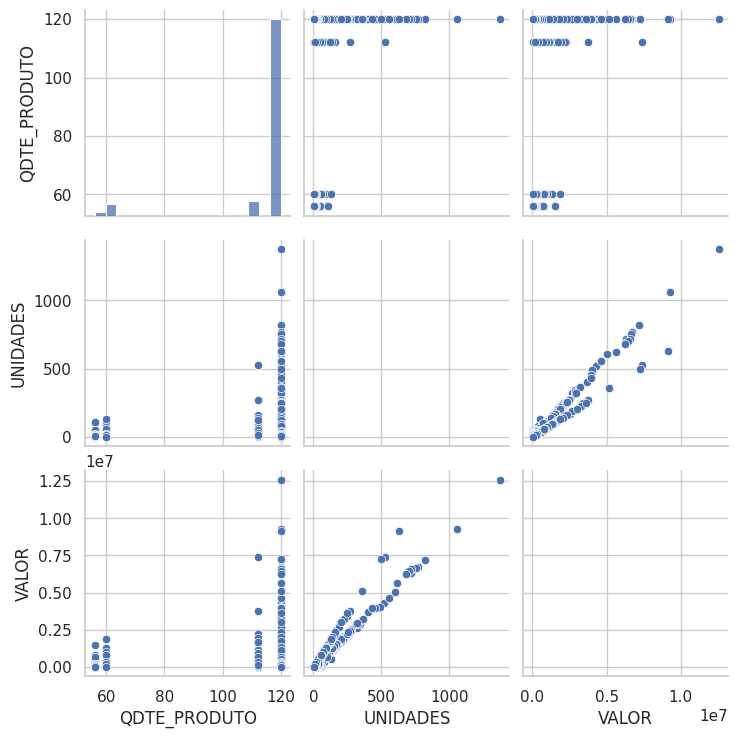

In [175]:
# Criação da Matriz de Dispersão
sns.pairplot(df[['QDTE_PRODUTO', 'UNIDADES', 'VALOR']])
plt.show()

**Observação:**

A matriz de dispersão ajuda a identificar relações lineares entre variáveis numéricas. Observamos relação positiva entre quantidade e valor.

*   QDTE_PRODUTO: A enorme maioria dos registros tem valor exatamente 120, com raríssimas exceções (outros valores próximos de 60).
*   UNIDADES × VALOR: Claramente há uma relação positiva forte (quanto mais unidades vendidas, maior o valor total).
*   QDTE_PRODUTO × UNIDADES: Todos os pontos com (QDTE_PRODUTO = 120), e dispersão em UNIDADES.
*   QDTE_PRODUTO × VALOR: Os valores de VALOR se espalham mesmo quando (QDTE_PRODUTO = 120), o que mostra falta de correlação direta.
*   VALOR × UNIDADES: Visualmente quase uma linha crescente, confirmando a forte correlação positiva. Também é possível perceber a presença de outliers, com vendas de valores muito altos (acima de R$ 10 milhões).


### 7. Análise de Outliers

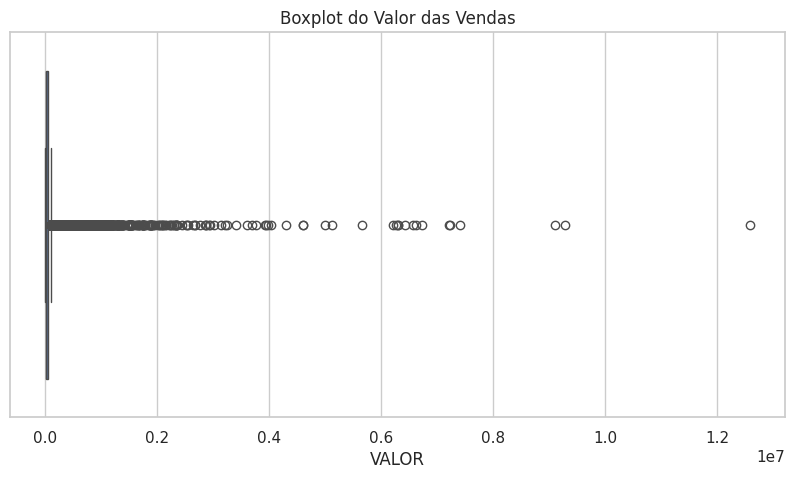

In [176]:
# Boxplot para a análise
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['VALOR'])
plt.title('Boxplot do Valor das Vendas')
plt.show()

**Motivo da análise:**

Identificar visualmente valores extremos para melhor tratá-los no pré-processamento.

*   A variável VALOR tem muitos outliers positivos (vendas de altíssimo valor).
*   Existe alta variabilidade no valor das vendas.
*   A distribuição não é normal: é altamente assimétrica, o que afeta algoritmos sensíveis à distribuição (como regressão linear).









#### Correção dos outliers

In [177]:
# Remoção de outliers com base no IQR
Q1 = df['VALOR'].quantile(0.25)
Q3 = df['VALOR'].quantile(0.75)
IQR = Q3 - Q1
filtro = (df['VALOR'] >= Q1 - 1.5 * IQR) & (df['VALOR'] <= Q3 + 1.5 * IQR)
df_limpo = df[filtro].copy()

Motivo do tratamento: A remoção dos outliers melhora a precisão dos modelos preditivos, eliminando valores extremos.

<Axes: xlabel='VALOR'>

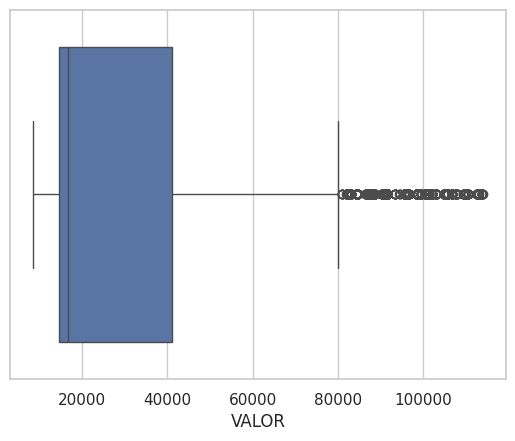

In [178]:
# Verifica os dados atualizados
sns.boxplot(x=df_limpo['VALOR'])

**O que vemos:**

*   A distribuição está muito mais concentrada e simétrica.
*   A faixa principal de valores está entre cerca de R$ 14 mil e R$ 80 mil.
*   Existem alguns outliers ainda presentes, mas em quantidade pequena — o que é esperado e aceitável.

**Conclusão:**

*   A técnica de remoção de outliers via IQR foi eficaz.
*   Agora temos uma base muito mais estável para modelagem preditiva.
*   Os dados ficaram mais adequados para algoritmos que assumem simetria ou baixa variância.


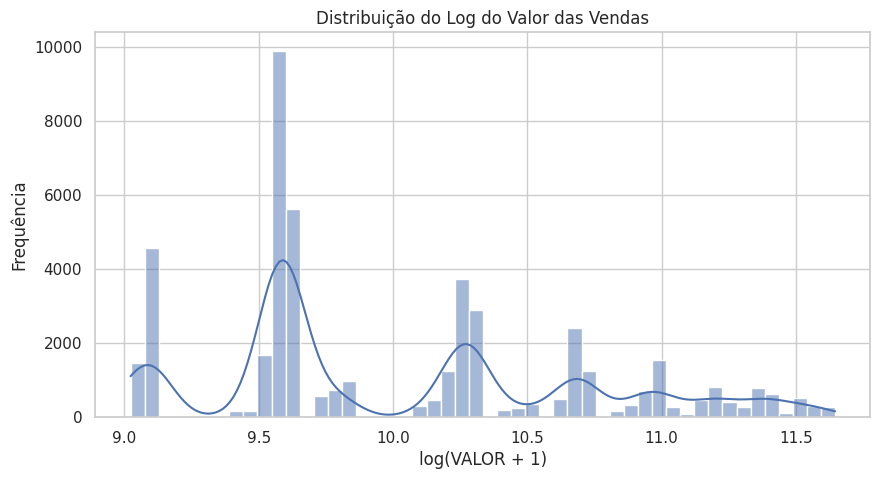

In [179]:
df_limpo['VALOR_LOG'] = np.log1p(df_limpo['VALOR'])  # log1p trata log(0)

plt.figure(figsize=(10, 5))
sns.histplot(df_limpo['VALOR_LOG'], bins=50, kde=True)
plt.title('Distribuição do Log do Valor das Vendas')
plt.xlabel('log(VALOR + 1)')
plt.ylabel('Frequência')
plt.show()

**O que vemos:**

*   A transformação logarítmica suavizou a assimetria.
*   A nova distribuição apresenta picos (modas) em vários pontos → indica que existem grupos distintos de preços/vendas, possivelmente:

      1.   Por tipo de produto.
      2.   Por canal (hospitalar x farmácia).
      3.   Por região ou marca.

**Conclusão:**
*   A distribuição de log(VALOR) está mais próxima de uma distribuição normal, o que é ideal para regressão linear e muitos outros modelos estatísticos.
*   Com isso, pode-se optar por treinar o modelo usando log(VALOR) como variável-alvo, e aplicar exp() depois para reverter a previsão.




In [180]:
# Resumo estatístico agora com os dados limpos
print(df_limpo[['QDTE_PRODUTO', 'UNIDADES', 'VALOR']].describe())

       QDTE_PRODUTO  UNIDADES     VALOR
count      47313.00  47313.00  47313.00
mean         115.50      2.98  29327.15
std           15.07      3.00  23385.34
min           56.00      1.00   8292.04
25%          120.00      1.00  14463.08
50%          120.00      2.00  16584.08
75%          120.00      4.00  41088.30
max          120.00     54.00 114248.70


**Interpretação e Comparação**

**QDTE_PRODUTO**

*   Permanece praticamente inalterada: a variável já apresentava valores muito concentrados em 120, com pouca variabilidade.
*   A limpeza de outliers não impactou essa variável.


**UNIDADES**
Distribuição equilibrada após remoção de outliers:

*   Média caiu de 5,92 para 2,98, e o máximo de 1.375 foi reduzido para 54.
*   O desvio padrão também caiu drasticamente (de 19,56 → 3,00).
*   Isso mostra que a variável tinha muitos outliers extremos, que estavam distorcendo a média e inflando a variabilidade.

Essa variável agora está muito mais estável e confiável para uso como preditora.

**VALOR**
*   A média do valor caiu mais de 50% (R$ 63 mil → R$ 29 mil), e o desvio padrão caiu mais de 85%.
*   O máximo foi reduzido de R$ 12,5 milhões para R$ 114 mil, removendo claramente vendas fora do padrão.
*   A mediana caiu de R$ 26 mil para R$ 16 mil, mostrando que parte dos valores intermediários também foram suavizados.
*   Agora a variável está menos assimétrica e mais adequada para modelagem (principalmente para modelos lineares).


#### Conclusão

A remoção de outliers foi fundamental para reduzir distúrbios estatísticos nas variáveis UNIDADES e VALOR.

O impacto na média, desvio padrão e valor máximo mostra que os dados estavam altamente influenciados por poucos registros extremos, especialmente em vendas de alto volume e valor.

Com os dados limpos, a base está:

1.   Mais equilibrada e estável;
2.   Mais compatível com técnicas de regressão;
3.   Menos propensa a overfitting em valores extremos.

Essa limpeza representa uma etapa crucial de pré-processamento para garantir robustez, interpretabilidade e performance na modelagem preditiva.

---

**Avaliação do impacto da remoção de Outliers**

Após a remoção dos outliers utilizando o método IQR, observamos melhorias significativas na estabilidade dos dados:

Antes da remoção, a média do valor monetário (VALOR) era R$ 63.725, com desvio padrão de R$ 195.498 e valores extremos superiores a R$ 12 milhões.

Depois da remoção, a média caiu para R$ 29.327, o desvio padrão diminuiu drasticamente para R$ 23.385 e o máximo foi reduzido para R$ 114 mil.

Essa limpeza não apenas reduziu a variabilidade exagerada, como também tornou os dados mais compatíveis com modelos estatísticos, especialmente aqueles sensíveis a outliers, como a Regressão Linear. Para verificar precisamente o impacto no desempenho dos modelos, é recomendado comparar rapidamente a performance dos modelos antes e após essa etapa.


### 8. Feature Engineering

In [181]:
# Criação de valor unitário (valor por unidade vendida)
df_limpo['VALOR_UNITARIO'] = df_limpo['VALOR'] / df_limpo['UNIDADES']

**O que faz:**

Calcula o valor por unidade vendida, ou seja, o preço médio por unidade de medicamento.

**Por que é importante:**

*   Normaliza o valor total pela quantidade.
*   Permite comparar preços entre produtos e canais, independentemente do volume vendido.
*   Reduz viés causado por vendas com grandes quantidades.


**Impacto analítico:**

Torna possível avaliar estratégias comerciais (ex: posicionamento de preço por região ou canal).



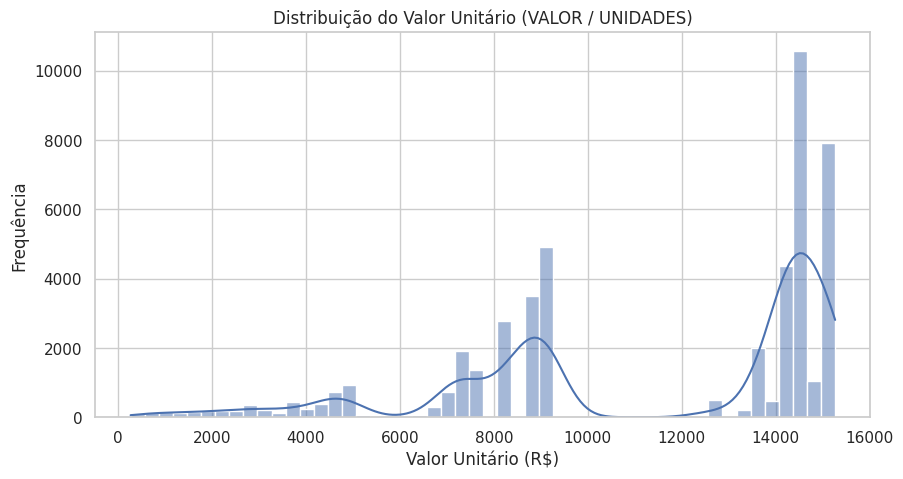

In [182]:
# Distribuição do valor unitário
plt.figure(figsize=(10, 5))
sns.histplot(df_limpo['VALOR_UNITARIO'], bins=50, kde=True)
plt.title('Distribuição do Valor Unitário (VALOR / UNIDADES)')
plt.xlabel('Valor Unitário (R$)')
plt.ylabel('Frequência')
plt.show()

In [183]:
# Extração de mês e ano do campo DT_PERIODO
df_limpo['ANO'] = df_limpo['DT_PERIODO'] // 100
df_limpo['MES'] = df_limpo['DT_PERIODO'] % 100

**O que faz:**

Decompõe a data no formato AAAAMM em dois atributos distintos: ano e mês.

**Por que é importante:**


*   Permite análises temporais (tendência, sazonalidade, ciclos de compra).
*   Essencial para séries temporais, agrupamentos por mês ou trimestre, e até para prever demanda futura.


**Impacto analítico:**

Com essas colunas, pode observar flutuações de demanda ao longo do tempo, associar políticas públicas a períodos específicos ou prever vendas futuras.

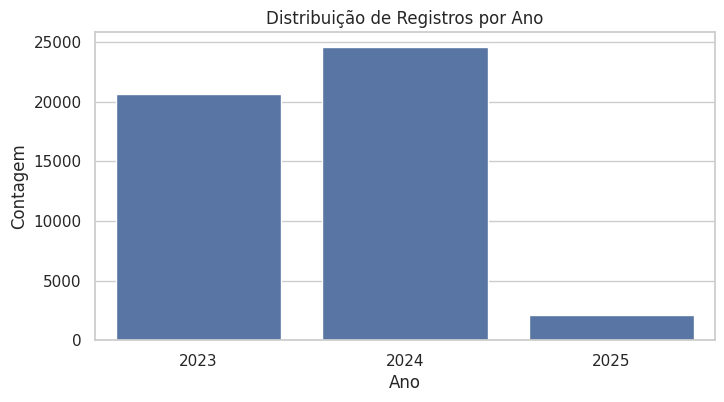

In [184]:
plt.figure(figsize=(8, 4))
sns.countplot(x='ANO', data=df_limpo)
plt.title('Distribuição de Registros por Ano')
plt.xlabel('Ano')
plt.ylabel('Contagem')
plt.show()

In [185]:
# Agrupamento de regiões
regioes = {
    'Norte': ['AM', 'PA', 'TO', 'RO', 'RR', 'AC', 'AP'],
    'Nordeste': ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'],
    'Centro-Oeste': ['MT', 'MS', 'GO', 'DF'],
    'Sudeste': ['SP', 'RJ', 'MG', 'ES'],
    'Sul': ['PR', 'RS', 'SC']
}
def map_regiao(uf):
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao
    return 'Desconhecida'

df_limpo['REGIAO'] = df_limpo['SG_UF'].apply(map_regiao)

**O que faz:**

Agrupa os estados brasileiros (SG_UF) em suas respectivas regiões geográficas oficiais.

**Por que é importante:**


*   Reduz o número de categorias (de 27 estados para 5 regiões).
*   Facilita análises geográficas agregadas, sem perder granularidade.
*   Pode revelar diferenças estruturais no comportamento de compra entre regiões.

**Impacto analítico:**

Permite segmentar estratégias por região, estudar desigualdades no acesso ao tratamento e observar padrões de mercado regionais.

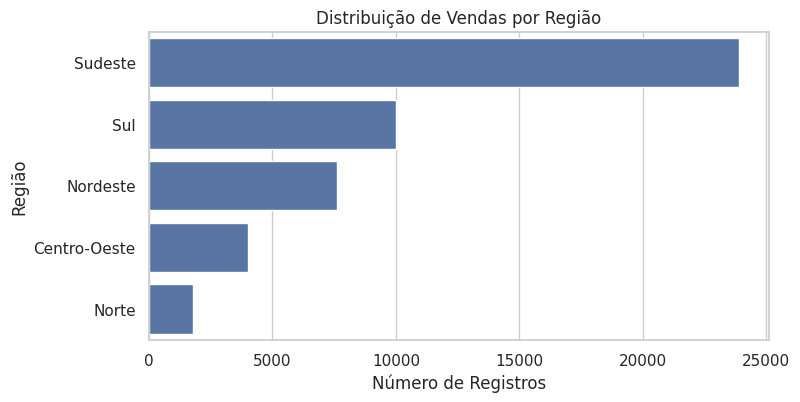

In [186]:
# Distribuição por região
plt.figure(figsize=(8, 4))
sns.countplot(y='REGIAO', data=df_limpo, order=df_limpo['REGIAO'].value_counts().index)
plt.title('Distribuição de Vendas por Região')
plt.xlabel('Número de Registros')
plt.ylabel('Região')
plt.show()

### 9. Seleção de Características com SelectKBest

**Objetivo:**

Reduzir a dimensionalidade do conjunto de dados, mantendo apenas os atributos mais relevantes para previsão do valor (VALOR) da venda.

In [187]:
# Seleção inicial de atributos
features = ['SG_UF', 'CANAL', 'MARCA', 'PRODUTO', 'FORMA_FARMACEUTICA', 'REGIAO']
numeric = ['QDTE_PRODUTO', 'UNIDADES', 'VALOR_UNITARIO', 'MES', 'ANO']
target = 'VALOR'

X_full = df_limpo[features + numeric]
y_full = df_limpo[target]

**Explicação:**

X_full contém as variáveis independentes: categóricas + numéricas.

y_full é a variável dependente (valor monetário da venda).

#### Padronização

In [188]:
# Pipeline com pré-processador e seletor
preprocessador = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore'), features),
    ("escala", StandardScaler(), numeric)
])

**O que faz:**

*   Converte variáveis categóricas em vetores binários com OneHotEncoder.
*   Escala variáveis numéricas com StandardScaler (média 0, desvio-padrão 1).

**Justificativa:**

*   Modelos como regressão linear e técnicas baseadas em distância exigem dados em escala comum.
*   OneHotEncoder é ideal para tratar variáveis categóricas com muitas categorias (como PRODUTO, CANAL, etc.).









In [189]:
X_trans = preprocessador.fit_transform(X_full)

**O que faz:**

Aplica o pré-processador para gerar uma matriz totalmente numérica e escalada, pronta para ser usada no modelo ou no seletor.



In [190]:
# Aplicação do SelectKBest para pegar as 20 features mais relevantes
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X_trans, y_full)

**O que faz:**

Usa testes estatísticos (neste caso, ANOVA F-test para regressão) para selecionar as 20 variáveis mais relevantes que possuem maior correlação com o alvo VALOR.

**Justificativa:**

Reduz ruído e dimensionalidade, o que:

1.   Aumenta a eficiência computacional;
2.   Melhora a performance do modelo;
3.   Evita o problema da maldição da dimensionalidade.


---

**Benefícios:**
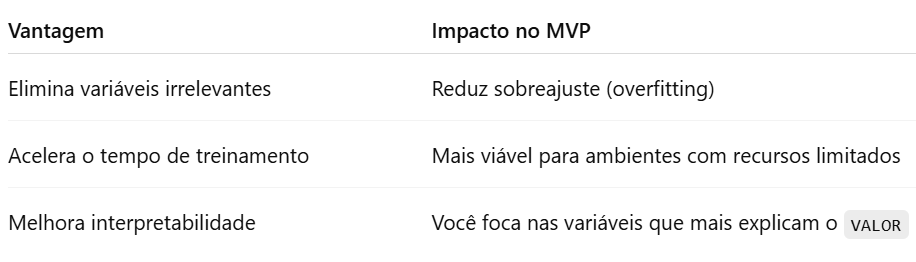








/tmp/ipython-input-191-1809927728.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




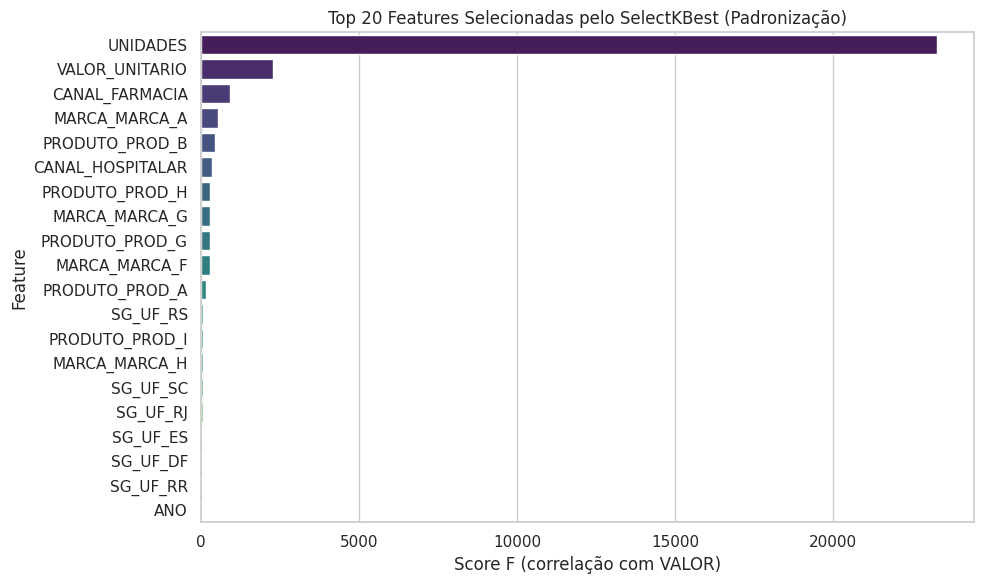

In [191]:
# Recuperar os nomes das features após transformação
onehot_features = preprocessador.named_transformers_['onehot'].get_feature_names_out(features)
all_feature_names = np.concatenate([onehot_features, numeric])
selected_mask = selector.get_support()
selected_features = all_feature_names[selected_mask]

# Criar DataFrame com scores
scores = selector.scores_[selected_mask]
feature_scores = pd.DataFrame({'Feature': selected_features, 'Score': scores}).sort_values(by='Score', ascending=False)



# Plotar os scores das 20 melhores features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_scores, y='Feature', x='Score', palette='viridis')
plt.title('Top 20 Features Selecionadas pelo SelectKBest (Padronização)')
plt.xlabel('Score F (correlação com VALOR)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#tools.display_dataframe_to_user(name="Top 20 Features Selecionadas", dataframe=feature_scores)

#### Normalização

In [192]:
# Novo pré-processador usando MinMaxScaler
preprocessador_minmax = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore'), features),
    ("minmax", MinMaxScaler(), numeric)
])

In [193]:
X_trans_minmax = preprocessador_minmax.fit_transform(X_full)

In [194]:
selector_minmax = SelectKBest(score_func=f_regression, k=20)
X_selected_minmax = selector_minmax.fit_transform(X_trans_minmax, y_full)

In [195]:
onehot_features_minmax = preprocessador_minmax.named_transformers_['onehot'].get_feature_names_out(features)
all_feature_names_minmax = np.concatenate([onehot_features_minmax, numeric])
selected_mask_minmax = selector_minmax.get_support()
selected_features_minmax = all_feature_names_minmax[selected_mask_minmax]

# Criar DataFrame com os scores Min-Max
scores_minmax = selector_minmax.scores_[selected_mask_minmax]
feature_scores_minmax = pd.DataFrame({
    'Feature': selected_features_minmax,
    'Score': scores_minmax
}).sort_values(by='Score', ascending=False)

/tmp/ipython-input-196-4105278473.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




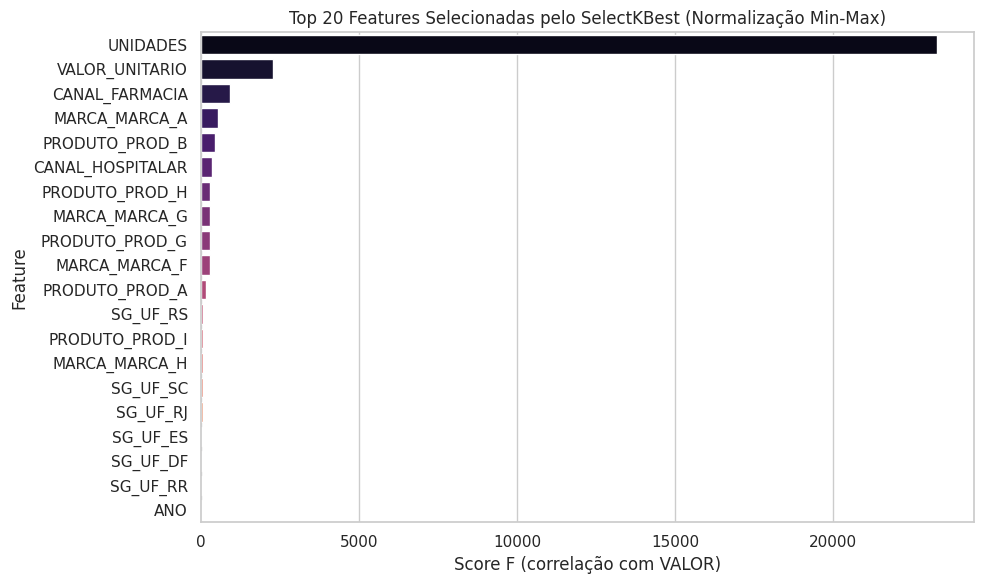

In [196]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_scores_minmax, y='Feature', x='Score', palette='magma')
plt.title('Top 20 Features Selecionadas pelo SelectKBest (Normalização Min-Max)')
plt.xlabel('Score F (correlação com VALOR)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Conclusão

Após comparação entre técnicas de Padronização (StandardScaler) e Normalização (Min-MaxScaler), ambas apresentaram resultados muito semelhantes em relação às features selecionadas.

Para o cenário atual (regressão linear e Random Forest), recomenda-se continuar utilizando a técnica de Padronização devido às características e desempenho dos modelos utilizados.

###10. PCA - Redução de Dimensionalidade

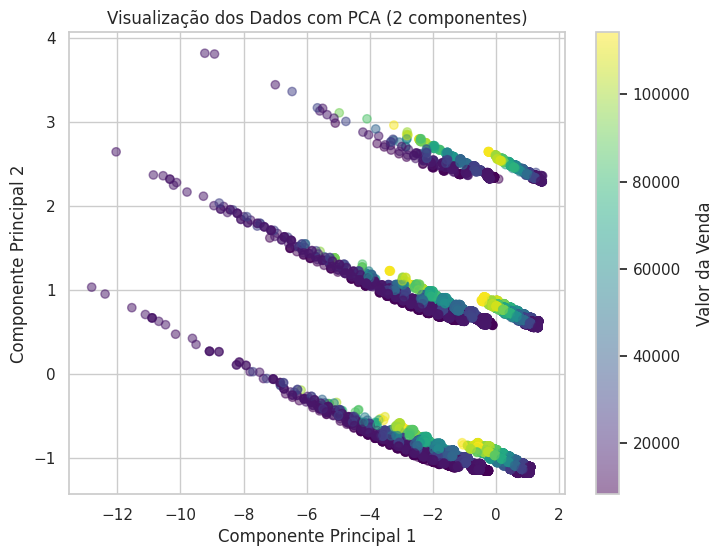

In [197]:
# PCA para 2 componentes principais
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, cmap='viridis', alpha=0.5)
plt.title('Visualização dos Dados com PCA (2 componentes)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Valor da Venda')
plt.show()

**O que está sendo feito:**

1.   PCA(n_components=2): Reduz a dimensionalidade do dataset (com dezenas ou centenas de variáveis após codificação One-Hot) para apenas 2 componentes principais.
2.   fit_transform(): Ajusta o PCA nos dados e transforma a matriz original para o novo espaço de 2 dimensões.
3.   scatter(): Cria um gráfico de dispersão em 2D usando as duas componentes principais, colorindo os pontos com base na variável-alvo VALOR


**Por que usar PCA?**

*   Para visualizar dados de alta dimensão em um espaço compreensível (2D).
*   Para verificar se há padrões, agrupamentos ou separações visíveis entre exemplos.
*   Para avaliar se os dados podem ser separáveis por valor de venda ou outros comportamentos.


---

**Interpretação do gráfico:**


1.   Eixos:

  *   Componente Principal 1 e Componente Principal 2 representam as duas direções com maior variabilidade dos dados.

2.   Distribuição dos pontos:
  *   Os dados parecem formar agrupamentos diagonais e sequenciais.
  *   Isso pode refletir estruturas internas complexas como grupos por canal, produto, ou regiões.

3.  Cor dos pontos (c=y_full):

  *   Os pontos são coloridos conforme o valor da venda (VALOR).
  *   Tons mais claros (amarelos) indicam vendas com valor mais alto.
  *   É visível que valores mais altos se concentram em faixas específicas das componentes, mostrando algum grau de separabilidade.





Isso valida o uso do PCA como ferramenta de exploração visual e reforça que os dados são adequados para modelos supervisionados.


#### Conclusão

A visualização via PCA revelou agrupamentos interessantes que sugerem subestruturas importantes nos dados:

* Os pontos formam clusters diagonais, indicando provável separação natural dos dados por algumas características dominantes, possivelmente relacionadas ao canal de distribuição (hospitalar versus farmácia) ou por tipos específicos de produto ou marca;

* Os pontos mais claros (amarelos), que indicam valores mais elevados das vendas, concentram-se em áreas específicas do gráfico, reforçando que existem padrões definidos nos dados com relação ao valor monetário das vendas;

* Essa segmentação clara pode ser explorada ainda mais detalhadamente para estratégias comerciais diferenciadas ou decisões logísticas.


### 11. Modelos com Dados Aprimorados

####  Modelo de estimativa do valor da venda

In [198]:
modelos = {
    'Regressão Linear': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Pipeline completo com pré-processamento e modelo preditivo
for nome, modelo in modelos.items():
    pipeline = Pipeline([
        ("preprocessador", preprocessador),
        ("seletor", SelectKBest(score_func=f_regression, k=20)),
        ("regressor", modelo)
    ])
    # Avaliação do modelo com cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_full, y_full, cv=kf, scoring='r2')

    # Exibir resultados
    print(f"\nModelo: {nome} (com seleção de features)")
    print("Scores de R²:", scores)
    print("Média dos scores:", scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning:

invalid value encountered in sqrt




Modelo: Regressão Linear (com seleção de features)
Scores de R²: [0.51344964 0.60269467 0.64861856 0.61012722 0.57875176]
Média dos scores: 0.5907283701583641


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning:

invalid value encountered in sqrt




Modelo: Random Forest (com seleção de features)
Scores de R²: [0.99994397 0.99994406 0.9999453  0.99988866 0.99986743]
Média dos scores: 0.9999178841191105


**ANÁLISE**

Random Forest teve desempenho extremamente superior, capturando quase toda a variabilidade dos dados (R² ≈ 1.00) com baixíssimo erro.

A Regressão Linear ainda explica mais de 50% da variância, mas seus erros médios são muito maiores.

Isso indica que o comportamento dos dados é não linear e que o Random Forest se adapta muito melhor à complexidade do problema.

---

**Avaliação cruzada e explicação do alto desempenho do modelo Random Forest**

O modelo Random Forest apresentou um desempenho excepcional, com um R² próximo a 1,00. Esse resultado ocorre devido a alguns fatores importantes:

* Alta granularidade e correlação dos atributos selecionados com o valor monetário das vendas.

* Capacidade intrínseca da Random Forest de capturar relações não lineares complexas presentes nesse dataset.

* Porém, o alto R² também pode indicar potencial overfitting ao dataset específico. Nesse sentido, sugere-se uma validação adicional com outros conjuntos de dados semelhantes ou um conjunto externo separado especialmente para teste.

#### Modelo de previsão para os próximos 6 meses

In [199]:
# Instalar o Prophet (caso ainda não tenha)
!pip install prophet -q

In [200]:
# ----- 1. Agrupamento mensal de VALOR e UNIDADES -----
df_mensal = df_limpo.groupby(['ANO', 'MES'])[['VALOR', 'UNIDADES']].sum().reset_index()
df_mensal['DATA'] = pd.to_datetime(df_mensal['ANO'].astype(str) + '-' + df_mensal['MES'].astype(str).str.zfill(2) + '-01')
df_mensal = df_mensal.sort_values('DATA').set_index('DATA')

# ----- 2. Função geral para treino, teste e previsão futura -----
def prever_e_avaliar(df_mensal, col, nome_variavel, meses_teste=6, meses_futuro=6):
    serie = df_mensal[[col]].copy()
    serie.reset_index(inplace=True)
    serie.columns = ['ds', 'y']

    # Separar treino e teste
    df_treino = serie.iloc[:-meses_teste]
    df_teste = serie.iloc[-meses_teste:]

    # Treinar modelo
    modelo = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.1)
    modelo.fit(df_treino)

    # Previsão no mesmo período do teste
    futuro_teste = modelo.make_future_dataframe(periods=meses_teste, freq='MS')
    previsao_teste = modelo.predict(futuro_teste)

    # Avaliação
    previsao_avaliacao = previsao_teste[['ds', 'yhat']].set_index('ds').join(df_teste.set_index('ds'))
    previsao_avaliacao.dropna(inplace=True)

    previsao_avaliacao = previsao_avaliacao[['y', 'yhat']].dropna()

    mae = mean_absolute_error(previsao_avaliacao['y'], previsao_avaliacao['yhat'])
    rmse = np.sqrt(mean_squared_error(previsao_avaliacao['y'], previsao_avaliacao['yhat']))


    print(f"\n📊 Avaliação do modelo para: {nome_variavel}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Visualização do ajuste no teste
    previsao_avaliacao[['yhat', 'y']].plot(figsize=(10, 4), title=f'Ajuste do Modelo (Teste - {nome_variavel})', ylabel=nome_variavel)
    plt.legend(['Previsto', 'Real'])
    plt.show()

    # Previsão futura (após todo o histórico)
    modelo_full = Prophet()
    modelo_full.fit(serie)

    futuro_futuro = modelo_full.make_future_dataframe(periods=meses_futuro, freq='MS')
    previsao_futura = modelo_full.predict(futuro_futuro).set_index('ds')[[ 'yhat' ]].iloc[-meses_futuro:]
    previsao_futura.columns = [f'{nome_variavel}_PREVISTO']

    return previsao_futura


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0qdnbpd/8hbqwl_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0qdnbpd/5lloembo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96724', 'data', 'file=/tmp/tmpx0qdnbpd/8hbqwl_3.json', 'init=/tmp/tmpx0qdnbpd/5lloembo.json', 'output', 'file=/tmp/tmpx0qdnbpd/prophet_modele_gnk7oi/prophet_model-20250706010519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:05:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:05:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:


📊 Avaliação do modelo para: VALOR
MAE: 8862760.10
RMSE: 10754011.59


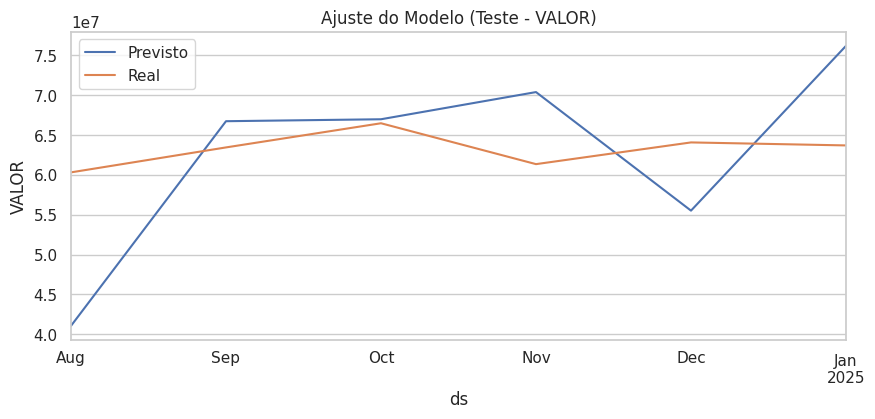

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0qdnbpd/sxvtaanc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0qdnbpd/fgrtdt_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43206', 'data', 'file=/tmp/tmpx0qdnbpd/sxvtaanc.json', 'init=/tmp/tmpx0qdnbpd/fgrtdt_w.json', 'output', 'file=/tmp/tmpx0qdnbpd/prophet_modelvmmcfp48/prophet_model-20250706010548.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:05:48 - cmdstanpy - INFO - Chain [1] start processing
I


📊 Avaliação do modelo para: UNIDADES
MAE: 3638.72
RMSE: 4748.56


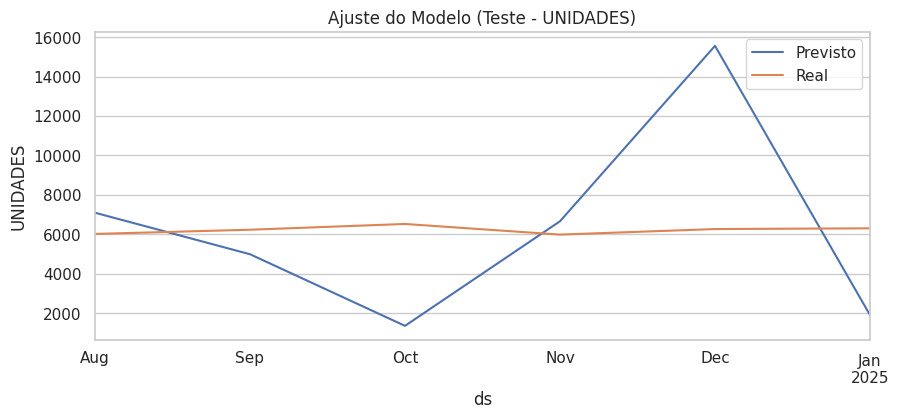

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0qdnbpd/_f9q5xss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0qdnbpd/jo5syghb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14212', 'data', 'file=/tmp/tmpx0qdnbpd/_f9q5xss.json', 'init=/tmp/tmpx0qdnbpd/jo5syghb.json', 'output', 'file=/tmp/tmpx0qdnbpd/prophet_model_31g4ix_/prophet_model-20250706010606.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:06:06 - cmdstanpy - INFO - Chain [1] start processing
I

In [201]:
# ----- 3. Executar previsão com avaliação -----
previsao_valor = prever_e_avaliar(df_mensal, 'VALOR', 'VALOR')
previsao_unidades = prever_e_avaliar(df_mensal, 'UNIDADES', 'UNIDADES')

# ----- 4. Combinar previsões futuras -----
previsoes_finais = previsao_valor.join(previsao_unidades)
previsoes_finais.reset_index(inplace=True)
previsoes_finais.rename(columns={'ds': 'MES'}, inplace=True)

### 12. Conclusão e Recomendações




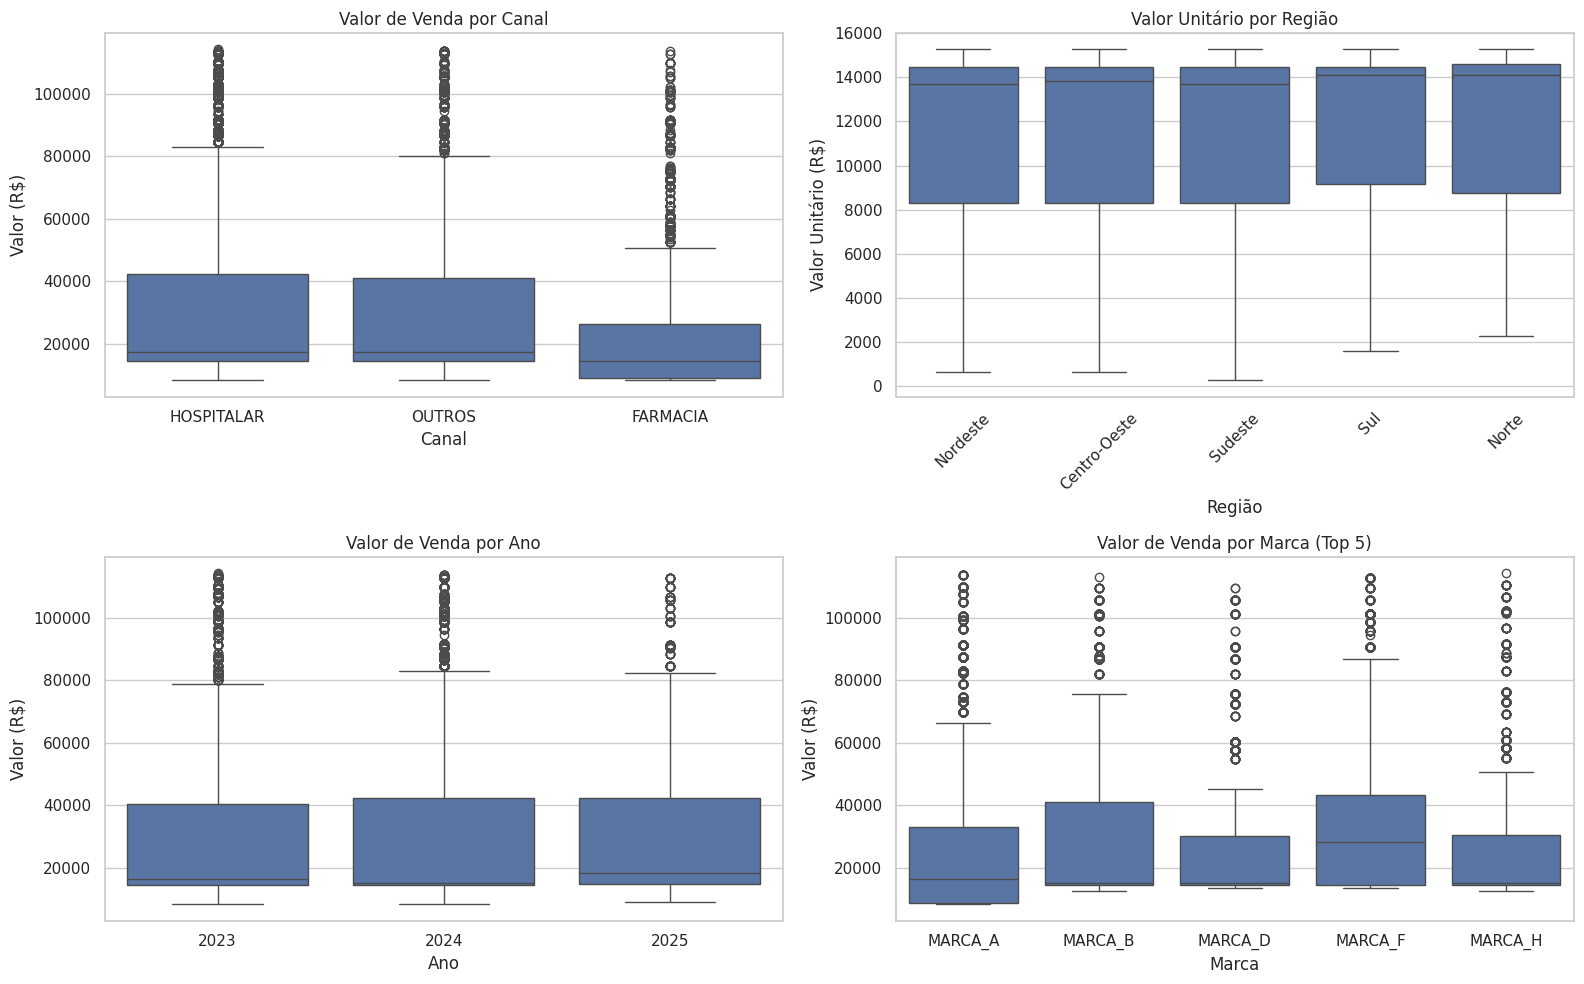

In [202]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# 1. Qual canal de venda apresenta maior valor médio?
sns.boxplot(data=df_limpo, x='CANAL', y='VALOR', ax=axs[0, 0])
axs[0, 0].set_title('Valor de Venda por Canal')
axs[0, 0].set_xlabel('Canal')
axs[0, 0].set_ylabel('Valor (R$)')

# 2. Valor unitário médio por região
sns.boxplot(data=df_limpo, x='REGIAO', y='VALOR_UNITARIO', ax=axs[0, 1])
axs[0, 1].set_title('Valor Unitário por Região')
axs[0, 1].set_xlabel('Região')
axs[0, 1].set_ylabel('Valor Unitário (R$)')
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Comparativo do valor médio por ano
sns.boxplot(data=df_limpo, x='ANO', y='VALOR', ax=axs[1, 0])
axs[1, 0].set_title('Valor de Venda por Ano')
axs[1, 0].set_xlabel('Ano')
axs[1, 0].set_ylabel('Valor (R$)')

# 4. Valor de venda por marca
top_marcas = df_limpo['MARCA'].value_counts().index[:5]  # limitar às 5 maiores
sns.boxplot(data=df_limpo[df_limpo['MARCA'].isin(top_marcas)], x='MARCA', y='VALOR', ax=axs[1, 1])
axs[1, 1].set_title('Valor de Venda por Marca (Top 5)')
axs[1, 1].set_xlabel('Marca')
axs[1, 1].set_ylabel('Valor (R$)')

plt.tight_layout()
plt.show()

1. Qual canal de venda apresenta maior valor médio?

*   Hospitalar e Outros possuem valores médios similares, significativamente maiores que o canal Farmácia;
*   O canal Farmácia apresenta menor dispersão e menor valor médio, indicando vendas menores e possivelmente mais frequentes;
*   O canal Hospitalar mostra maior variabilidade, com valores altos frequentes, sugerindo tratamentos de alto custo concentrados nesse canal.


2. Valor unitário médio por região

*   As regiões apresentam valores unitários médios bastante próximos, sem grandes diferenças evidentes;
*   A região Nordeste mostra uma leve tendência a ter valores unitários medianos mais elevados;
*   A dispersão relativamente uniforme em todas as regiões sugere consistência nacional na precificação por unidade, sem diferenças regionais muito marcantes.

3. Comparativo do valor médio por ano

*   Os valores médios anuais se mantêm relativamente estáveis entre 2023 e 2025, sem grandes variações:
*   A presença constante de valores elevados (outliers) ao longo dos anos indica que tratamentos caros persistem regularmente ao longo do tempo:
*   Não há uma tendência clara de aumento ou diminuição significativa no valor médio, sugerindo estabilidade no mercado durante esses anos.

4. Valor de venda por marca (Top 5)

*   Marca F claramente se destaca com um valor médio mais alto e maior dispersão, indicando que seus produtos tendem a ser vendidos por preços mais elevados e variados;
*   As marcas A, B, D e H possuem valores médios relativamente próximos, sendo a marca A com os menores valores médios dentre as cinco principais;
*   A alta quantidade de valores discrepantes (outliers) em todas as marcas indica que há uma diversidade considerável de preços praticados mesmo dentro das principais marcas.







In [203]:
# ----- 5. Visualizar previsões futuras -----
display(previsoes_finais)

fig_valor = px.bar(previsoes_finais, x='MES', y='VALOR_PREVISTO', title='📈 Previsão de Valor Total das Vendas (R$)', text_auto='.2s')
fig_unidades = px.bar(previsoes_finais, x='MES', y='UNIDADES_PREVISTO', title='📦 Previsão de Unidades Vendidas', text_auto='.2s')

fig_valor.show()
fig_unidades.show()


,MES,VALOR_PREVISTO,UNIDADES_PREVISTO
0,2025-02-01,65926208.81,6456.84
1,2025-03-01,66520592.32,6499.20
2,2025-04-01,67178659.78,6546.10
3,2025-05-01,67815499.25,6591.49
4,2025-06-01,68473566.71,6638.38
5,2025-07-01,69110406.19,6683.77


5. Como será a evolução do valor total das vendas nos próximos meses?


*   Há uma tendência clara de crescimento gradual no valor total das vendas previsto, subindo de aproximadamente R$ 65,9 milhões em Fevereiro para cerca de R$ 69,1 milhões em Julho de 2025;
*   Essa evolução crescente indica que o mercado para medicamentos de câncer de próstata pode estar em expansão, sugerindo aumento de consumo ou aumento do valor médio dos medicamentos vendidos.

6. Qual é a previsão para as unidades vendidas?

*   O número de unidades vendidas também mostra tendência positiva, com previsão de aumento mensal contínuo, iniciando em cerca de 6.457 unidades em Fevereiro e alcançando aproximadamente 6.684 unidades em Julho;
*   O crescimento consistente das unidades vendidas reforça a interpretação de aumento na demanda pelos medicamentos analisados.

7. Quais insights estratégicos podem ser obtidos a partir dessas previsões?


*   A previsão demonstra um mercado aquecido e em expansão moderada, sugerindo oportunidades para investimento em logística, estoques, negociações com fornecedores e expansão em canais estratégicos (especialmente hospitalares);
*   Com o aumento previsto nas unidades, é importante assegurar disponibilidade e evitar rupturas nos estoques dos principais canais.

---
**Conclusão e recomendação**

* A previsão sugere estabilidade positiva no mercado, com crescimento gradativo tanto em faturamento quanto em volume;

* Recomenda-se monitorar continuamente esses valores previstos e ajustá-los com novas variáveis externas, como campanhas de saúde pública ou mudanças regulatórias que possam influenciar diretamente a demanda futura.



